#### Compute adjacency complex to track persistence

In [1]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle as pickle
from pylab import *
import os    
import numpy as np

import warnings

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import io
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageChops, ImageFont
import shapely.geometry as geom
from shapely.ops import unary_union
import gudhi
from persim import PersistenceImager

import invr

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# get the list of folders in a location
def get_folders(location):
    return [name for name in os.listdir(location) if os.path.isdir(os.path.join(location, name))]

In [3]:
states = get_folders('/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/data/processed data/svi with hepvu/2018/SVI2018 census tracts with death rate HepVu-5 classes')

In [4]:
print('Number of states:', len(states))
print(states)

Number of states: 50
['VT', 'VA', 'SD', 'SC', 'UT', 'GA', 'MS', 'MT', 'MO', 'MA', 'AK', 'KY', 'AL', 'NH', 'MN', 'MI', 'OK', 'IN', 'CO', 'CA', 'IA', 'CT', 'FL', 'WV', 'RI', 'WY', 'TX', 'PA', 'NC', 'ND', 'NM', 'NJ', 'ME', 'AR', 'NV', 'MD', 'KS', 'NE', 'HI', 'DE', 'AZ', 'NY', 'ID', 'OH', 'OR', 'IL', 'LA', 'WI', 'WA', 'TN']


In [5]:
selected_variables_without_y = ['EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']


selected_variables_for_state_with_geo = ['FIPS','EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','NOD_Rate','geometry']
selected_variables_for_state = ['EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']

selected_variables_with_censusinfo = ['FIPS','STCNTY','EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','NOD_Rate','geometry']


In [6]:
# def generate_adjacent_counties(dataframe,filtration_threshold,variable_name):
def generate_adjacent_counties(dataframe,variable_name):


    filtered_df = dataframe
    # filtered_df = dataframe[dataframe[variable_name] < filtration_threshold]

    # Perform a spatial join to find adjacent precincts
    adjacent_counties = gpd.sjoin(filtered_df, filtered_df, predicate='intersects', how='left')

    # Filter the results to include only the adjacent states
    adjacent_counties = adjacent_counties.query('sortedID_left != sortedID_right')

    # Group the resulting dataframe by the original precinct Name and create a list of adjacent precinct Name
    adjacent_counties = adjacent_counties.groupby('sortedID_left')['sortedID_right'].apply(list).reset_index()

    adjacent_counties.rename(columns={'sortedID_left': 'county', 'sortedID_right': 'adjacent'}, inplace=True)

    adjacencies_list = adjacent_counties['adjacent'].tolist()
    county_list = adjacent_counties['county'].tolist()

    merged_df = pd.merge(adjacent_counties, dataframe, left_on='county',right_on='sortedID', how='left')
    merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry')

    return adjacencies_list,merged_df,county_list

In [7]:
def form_simplicial_complex(adjacent_county_list,county_list):
    max_dimension = 3

    V = []
    V = invr.incremental_vr(V, adjacent_county_list, max_dimension,county_list)

    return V

In [8]:
# Create a folder for each variable if it does not exist
for variable in selected_variables_without_y:
    os.makedirs(f'/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/results/adjacency_persitence_images/states_h1_1/{variable}', exist_ok=True)
print('Done creating folders for each variable')

Done creating folders for each variable


In [9]:
# create an empty dataframe with the columns county, H0, H1, No Persistence
columns = ['state','census_c','variable','H0','H1','No Persistence']
summary_df = pd.DataFrame(columns=columns)


In [11]:
for state in states:

    print('Processing:', state)

    svi_od = gpd.read_file(f'/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/data/processed data/svi with hepvu/2018/SVI2018 census tracts with death rate HepVu-5 classes/{state}/{state}.shp')
    
    # Drop -999 in selected_variables_for_state
    for variable in selected_variables_for_state:
        svi_od = svi_od[svi_od[variable] != -999]

    svi_od_filtered_state = svi_od[selected_variables_with_censusinfo]

    #reset index
    svi_od_filtered_state = svi_od_filtered_state.reset_index(drop=True)

    # Main code

    for variable_name in selected_variables_without_y:
        
        # Cahanged FIPS into STCNTY
        df_one_variable = svi_od_filtered_state[['STCNTY',variable_name, 'geometry']]

        # # Sorting the DataFrame based on the 'rate' column
        df_one_variable = df_one_variable.sort_values(by=variable_name)
        df_one_variable['sortedID'] = range(len(df_one_variable))

        # Convert the DataFrame to a GeoDataFrame
        df_one_variable = gpd.GeoDataFrame(df_one_variable, geometry='geometry')
        df_one_variable.crs = "EPSG:3395"  # This is a commonly used projected CRS

        # Heter thresho;d removed from original adj method - change it later
        adjacencies_list,adjacent_counties_df,county_list = generate_adjacent_counties(df_one_variable,variable_name)

        # create a dictionary adjacent_counties_df column county as key and column adjacent as value(to avoid NULL adjacencies error)
        adjacent_counties_dict = dict(zip(adjacent_counties_df['county'],adjacent_counties_df['adjacent']))

        # this take only counties that have adjacent counties
        county_list = adjacent_counties_df['county'].tolist()

        simplices = form_simplicial_complex(adjacent_counties_dict,county_list)

        #NEW code from here

        st = gudhi.SimplexTree()
        st.set_dimension(2)

        for simplex in simplices:
            if len(simplex) == 1:
                st.insert([simplex[0]], filtration=0.0)
        
        for simplex in simplices:
            if len(simplex) == 2:
                last_simplex = simplex[-1]
                filteration_value = df_one_variable.loc[df_one_variable['sortedID'] == last_simplex, variable_name].values[0]
                st.insert(simplex, filtration=filteration_value)

        for simplex in simplices:
            if len(simplex) == 3:
                last_simplex = simplex[-1]
                filteration_value = df_one_variable.loc[df_one_variable['sortedID'] == last_simplex, variable_name].values[0]
                st.insert(simplex, filtration=filteration_value)

        #Compute persistence
        st.compute_persistence()

        persistence = st.persistence()

        if len(persistence) > 0:

            # intervals_dim0 = st.persistence_intervals_in_dimension(0)
            intervals_dim1 = st.persistence_intervals_in_dimension(1)

            # # add to summary_df
            # new_row = {'state': state,'census_c':len(df_one_variable),'variable': variable_name , 'H0': len(intervals_dim0), 'H1':len(intervals_dim1) , 'No Persistence': "False"}

            # summary_df = pd.concat([summary_df, pd.DataFrame([new_row])], ignore_index=True)


            pdgms = intervals_dim1
            # pdgms = intervals

            #REPLACE INF WITH ZERO
            for i in range(len(pdgms)):
                if np.isinf(pdgms[i][1]):
                    pdgms[i][1] = 0

                if np.isinf(pdgms[i][0]):
                    pdgms[i][0] = 0

            # remove the first 30% points



            pimgr = PersistenceImager(pixel_size=0.05)
            pimgr.fit(pdgms, skew=True)

            pimgs = pimgr.transform(pdgms, skew=True)

            print(variable_name)




            # The `plot_diagram()` and `plot_image()` methods can be used to visualize persistence diagrams and images
            fig, axs = plt.subplots(1, 3, figsize=(10,5))

            axs[0].set_title("Original Diagram")
            pimgr.plot_diagram(pdgms, skew=False, ax=axs[0])

            axs[1].set_title("Birth-Persistence\nCoordinates")
            pimgr.plot_diagram(pdgms, skew=True, ax=axs[1])

            axs[2].set_title("Persistence Image")
            pimgr.plot_image(pimgs, ax=axs[2])

            plt.tight_layout()
            plt.savefig(f'/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/results/adjacency_persitence_images/states_h1_1/{variable_name}/{state}.png')



        else:
            # new_row = {'state': state,'census_c':len(df_one_variable),'variable': variable_name , 'H0': np.nan, 'H1':np.nan , 'No Persistence': "True"}
            # summary_df = pd.concat([summary_df, pd.DataFrame([new_row])], ignore_index=True)
            pass

        # break
    # break

print('All states processed.')

Processing: VT
EP_POV
EP_UNEMP


: 

In [ ]:
# summary_df

,state,census_c,variable,H0,H1,No Persistence
0,VT,183,EP_POV,183,17,False
1,VT,183,EP_UNEMP,183,19,False
2,VT,183,EP_PCI,183,11,False
3,VT,183,EP_NOHSDP,183,19,False
4,VT,183,EP_UNINSUR,183,13,False
...,...,...,...,...,...,...
795,TN,1473,EP_MUNIT,1139,173,False
796,TN,1473,EP_MOBILE,1191,144,False
797,TN,1473,EP_CROWD,1302,184,False
798,TN,1473,EP_NOVEH,1466,192,False


In [ ]:
# # for each variable get number rows that are null
# for variable in selected_variables_without_y:
#     print('Variable:', variable)
#     print(summary_df[summary_df['variable'] == variable].isnull().sum())

Variable: EP_POV
state             0
census_c          0
variable          0
H0                0
H1                0
No Persistence    0
dtype: int64
Variable: EP_UNEMP
state             0
census_c          0
variable          0
H0                0
H1                0
No Persistence    0
dtype: int64
Variable: EP_PCI
state             0
census_c          0
variable          0
H0                0
H1                0
No Persistence    0
dtype: int64
Variable: EP_NOHSDP
state             0
census_c          0
variable          0
H0                0
H1                0
No Persistence    0
dtype: int64
Variable: EP_UNINSUR
state             0
census_c          0
variable          0
H0                0
H1                0
No Persistence    0
dtype: int64
Variable: EP_AGE65
state             0
census_c          0
variable          0
H0                0
H1                0
No Persistence    0
dtype: int64
Variable: EP_AGE17
state             0
census_c          0
variable          0
H0        

In [ ]:
# # GET THE MAXIMUM H1 VALUE
# max_h1 = summary_df['H1'].max()

# max_h1

1031

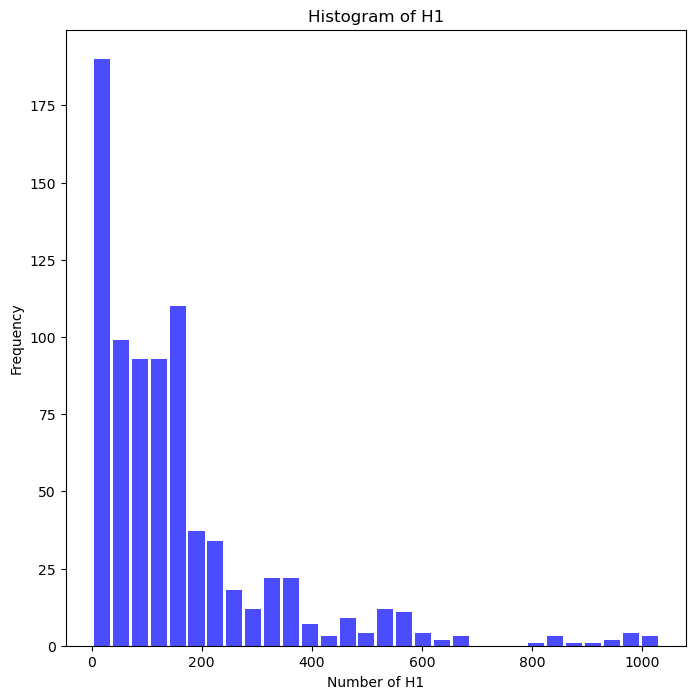

In [ ]:
# # plot H1 histogram using matplotlib and only H1 between 0-60

# summary_df__ = summary_df[summary_df['H1'] <= 10]

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.hist(summary_df['H1'], bins=30, color='blue', alpha=0.7, rwidth=0.85)
# ax.set_xlabel('Number of H1')
# ax.set_ylabel('Frequency')
# ax.set_title('Histogram of H1')
# plt.show()



In [ ]:
# get the unique count in the summary_df H1
# summary_df[summary_df['variable'] == 'EP_POV']['H1'].value_counts()


In [ ]:
# # save the summary_df to a csv file

# summary_df.to_csv('/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/results/test/summary_df_full_data_STATE.csv', index=False)